In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

In [2]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [71]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
from scipy.sparse import hstack

## Обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [34]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [36]:
# Немного скорректируем данные по давлению. Заменим отрицательные и слишком малые значения.
t = df[df['ap_hi'] < 0].index
df.iloc[t, 5] = -(df.iloc[t, 5])

lo_cor = df[df['ap_lo'] < 0].index
df.iloc[lo_cor, 6] = -(df.iloc[lo_cor, 6])  

In [46]:
cor_pr = df[df['ap_hi'] < 50].index
df.iloc[cor_pr, 5] = df.iloc[cor_pr, 5]*10

In [55]:
# Сделаем из пола бинарный признак
df['gender'] = df['gender'] - 1

In [56]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,0.349571,164.359229,74.205690,129.134957,96.632414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,153.882217,188.471505,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,0.000000,55.000000,10.000000,10.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,0.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,0.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,1.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,1.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


Разделим наши данные на тренировочную и тестовую выборки

In [172]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [57]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- cholesterol, gluc применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gender, smoke, alco, active - оставим пока как есть

In [58]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [59]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['cholesterol', 'gluc']
base_cols = ['gender', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [61]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Логистическая регрессия. Классификатор и кросс-валидация

In [117]:
classifier = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7897912430187114+-0.0061329048412925875


Градиентный бустинг. Классификатор и кросс-валидация

In [74]:
from sklearn.linear_model import SGDClassifier

In [83]:
classifier_SGD = Pipeline([
    ('features',feats),
    ('classifier', SGDClassifier(loss='log',random_state = 42, max_iter=1000)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_SGD, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_SGD.fit(X_train, y_train)
y_score_SGD = classifier_SGD.predict_proba(X_test)[:, 1]

CV score is 0.7881136243674287+-0.00757382530411766


Случайный лес. Классификатор и кросс-валидация

In [96]:
from sklearn.ensemble import RandomForestClassifier

In [97]:
classifier_RF = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(n_estimators=50,random_state = 42, max_depth=5)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_RF, X_train, y_train, cv=10, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_RF.fit(X_train, y_train)
y_score_RF = classifier_RF.predict_proba(X_test)[:, 1]

CV score is 0.7946590767988575+-0.005637966474609235


Посчитаем precision/recall/f_score для Регрессии

In [118]:
b=1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.385686, F-Score=0.732, Precision=0.652, Recall=0.834


Для градиентного бустинга

In [84]:
b=1
precision_sgd, recall_sgd, thresholds_sgd = precision_recall_curve(y_test.values, y_score_SGD)
fscore_sgd = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix_sgd = np.argmax(fscore_sgd)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_sgd[ix_sgd], 
                                                                        fscore_sgd[ix_sgd],
                                                                        precision_sgd[ix_sgd],
                                                                        recall_sgd[ix_sgd]))

Best Threshold=0.388852, F-Score=0.732, Precision=0.651, Recall=0.833


Для случаного леса

In [133]:
b=1
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test.values, y_score_RF)
fscore_rf = (1+b**2)*(precision * recall) / (b**2*precision + recall)
# locate the index of the largest f score
ix_rf = np.argmax(fscore_rf)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_rf[ix_rf], 
                                                                        fscore_rf[ix_rf],
                                                                        precision_rf[ix_rf],
                                                                        recall_rf[ix_rf]))

Best Threshold=0.600209, F-Score=0.732, Precision=0.810, Recall=0.570


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

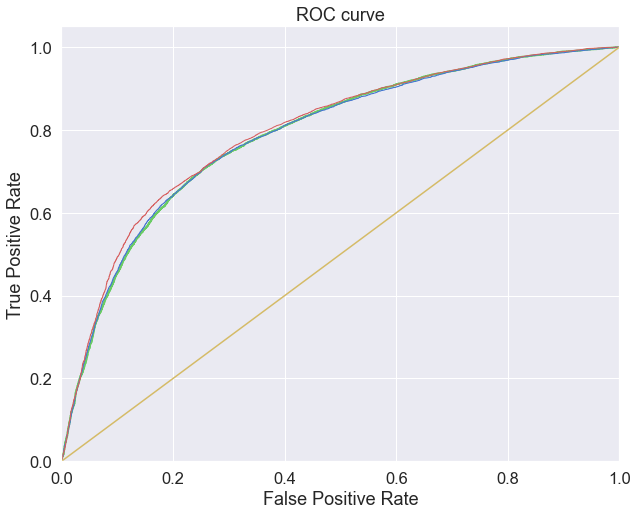

In [134]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thres = roc_curve(y_test, y_score, pos_label=1)
fpr_sgd, tpr_sgd, thres = roc_curve(y_test, y_score_SGD, pos_label=1)
fpr_rf, tpr_rf, thres = roc_curve(y_test, y_score_RF, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, color = 'g', label='ROC curve Reg')
plt.plot(fpr_sgd, tpr_sgd, lw=1,color = 'b', label='ROC curve SGD')
plt.plot(fpr_rf, tpr_rf, lw=1,color = 'r', label='ROC curve RF')
plt.plot([0, 1], [0, 1], color = 'y')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

In [ ]:
По графику видно, что все модели ведут себя похожим образом с небольшим перевесом за Лесом.

In [119]:
roc_auc_reg = roc_auc_score(y_true=y_test, y_score=y_score)
log_ls_reg = log_loss(y_true=y_test, y_pred=y_score)
roc_auc_sgd = roc_auc_score(y_true=y_test, y_score=y_score_SGD)
log_ls_sgd = log_loss(y_true=y_test, y_pred=y_score_SGD)
roc_auc_rf = roc_auc_score(y_true=y_test, y_score=y_score_RF)
log_ls_rf = log_loss(y_true=y_test, y_pred=y_score_RF)
#Ваш код здесь
print("roc auc score: {}".format(roc_auc_reg))
print("log loss score: {}".format(log_ls_reg))
print("roc auc score: {}".format(roc_auc_sgd))
print("log loss score: {}".format(log_ls_sgd))
print("roc auc score: {}".format(roc_auc_rf))
print("log loss score: {}".format(log_ls_rf))

roc auc score: 0.7883215644168573
log loss score: 0.5693810869797408
roc auc score: 0.7881519796858836
log loss score: 0.5724431300951011
roc auc score: 0.7957566067901815
log loss score: 0.5567610935414224


Посомтрим на матрицу ошибок для регрессии

Confusion matrix, without normalization
[[4949 3871]
 [1441 7239]]


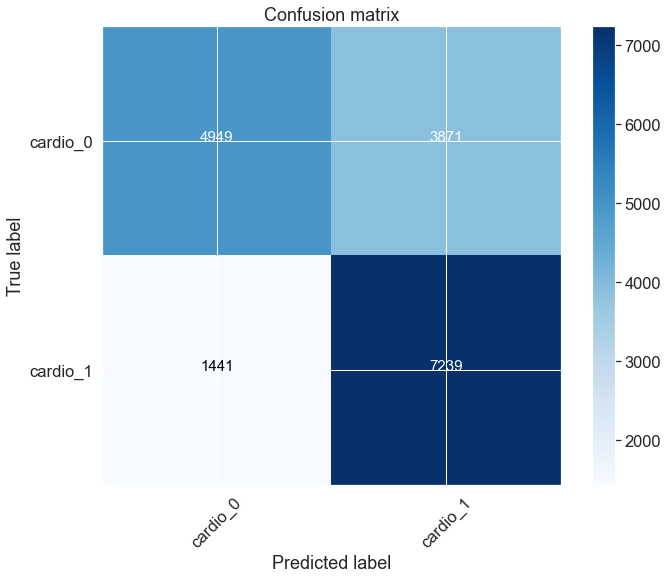

In [135]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [136]:
def TP_FP_ev(cnf_matrix):
    TN = cnf_matrix[0][0]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]
    FP = cnf_matrix[0][1]

    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    TNR = TN/(FP+TN)
    return TPR, FPR, TNR

In [137]:
TPR_reg, FPR_reg, TNR_reg = TP_FP_ev(cnf_matrix)
print(TPR_reg, FPR_reg, TNR_reg)

0.8339861751152073 0.4388888888888889 0.5611111111111111


Неплохой уровень определения заболевших, но и ошибочно отнесенных к заболевшим также высокий

Для бустинга

Confusion matrix, without normalization
[[ 633 8187]
 [  77 8603]]


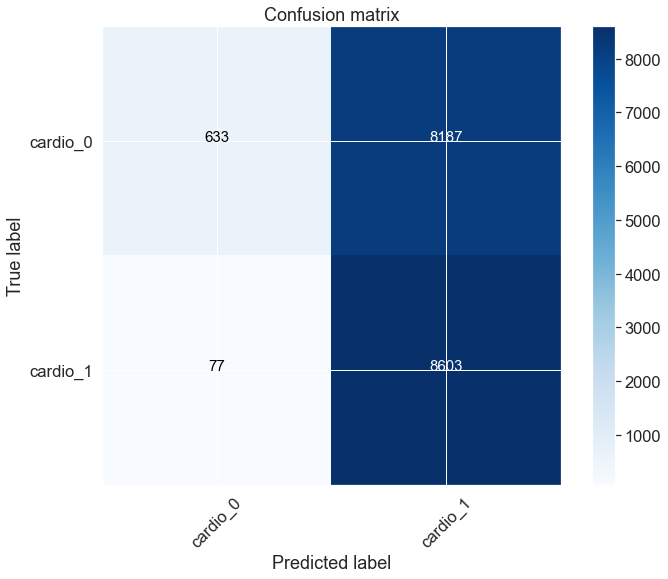

In [138]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_sgd = confusion_matrix(y_test, y_score_SGD>thresholds_sgd[ix_sgd])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_sgd, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [139]:
TPR_sgd, FPR_sgd, TNR_sgd = TP_FP_ev(cnf_matrix_sgd)
print(TPR_sgd, FPR_sgd, TNR_sgd)

0.9911290322580645 0.9282312925170068 0.0717687074829932


Наивысший уровень определения заболевших, но также практически 100% отнесены ложно к заболевшим. Модель близка к константе - считать всех заболевшими.

Для случайного леса

Confusion matrix, without normalization
[[7661 1159]
 [3732 4948]]


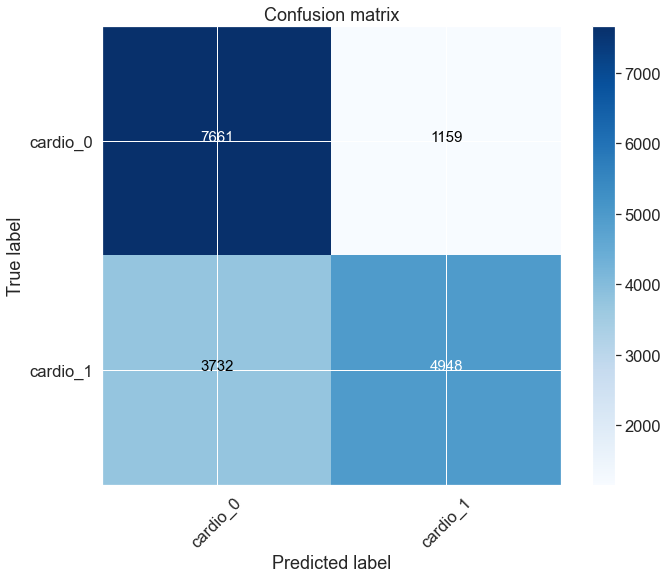

In [140]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_rf = confusion_matrix(y_test, y_score_RF>thresholds_rf[ix_rf])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_rf, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig("conf_matrix_rf.png")
plt.show()

In [141]:
TPR_rf, FPR_rf, TNR_rf = TP_FP_ev(cnf_matrix_rf)
print(TPR_rf, FPR_rf, TNR_rf)

0.5700460829493088 0.13140589569161 0.86859410430839


Только 57% отловили заболевших, но при этом высокий показатель по здоровым.

In [151]:
rubl_to_test = 1400
rubl_to_early_treatment = 15000
rubl_to_late_treatment = 20000
rubl_all_test = np.sum(cnf_matrix) * rubl_to_test + (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_early_treatment
rubl_1 = (cnf_matrix[1][0]+cnf_matrix[1][1]) * rubl_to_late_treatment
print('расходы, если не делать тест и ждать симптомов:',rubl_1)
print('расходы, если делать тест всем и лечить группу больных:',rubl_all_test)


расходы, если не делать тест и ждать симптомов: 173600000
расходы, если делать тест всем и лечить группу больных: 154700000


In [163]:
def treat_cost_ML(cnf_matrix):    
    rubl_to_test = 1400
    rubl_to_early_treatment = 15000
    rubl_to_late_treatment = 20000

    rubl_ML = 1/1000*((cnf_matrix[0][1]+cnf_matrix[1][1]) * rubl_to_test + 
                      (cnf_matrix[1][0]) * rubl_to_late_treatment + 
                      np.sum(cnf_matrix[1][1]) * rubl_to_early_treatment)
    print('Расходы при анализе результатов МЛ:',rubl_ML)
    return rubl_ML

In [164]:
cost_reg = treat_cost_ML(cnf_matrix)
cost_sgd = treat_cost_ML(cnf_matrix_sgd)
cost_rf = treat_cost_ML(cnf_matrix_rf)

Расходы при анализе результатов МЛ: 152959.0
Расходы при анализе результатов МЛ: 154091.0
Расходы при анализе результатов МЛ: 157409.80000000002


In [155]:
from tabulate import tabulate

In [169]:
table=[['Reg', roc_auc_reg, fscore[ix], precision[ix], recall[ix], cost_reg],
       ['SGD', roc_auc_sgd, fscore_sgd[ix_sgd], precision_sgd[ix_sgd], recall_sgd[ix_sgd], cost_sgd],
       ['RF', roc_auc_rf, fscore_rf[ix_rf], precision_rf[ix_rf], recall_rf[ix_rf], cost_rf]]
headers=["Type", "Roc_auc","F-score", "Precision","Recall", "Costs"]
print(tabulate(table, headers, tablefmt="grid"))

+--------+-----------+-----------+-------------+----------+---------+
| Type   |   Roc_auc |   F-score |   Precision |   Recall |   Costs |
+========+===========+===========+=============+==========+=========+
| Reg    |  0.788322 |  0.731646 |    0.651607 | 0.834101 |  152959 |
+--------+-----------+-----------+-------------+----------+---------+
| SGD    |  0.788152 |  0.731646 |    0.650652 | 0.83318  |  154091 |
+--------+-----------+-----------+-------------+----------+---------+
| RF     |  0.795757 |  0.731646 |    0.810249 | 0.570161 |  157410 |
+--------+-----------+-----------+-------------+----------+---------+


С точки зрения метрик ML наилучшая модели близки, но небольшое преимущество у Случаного Леса.
Но бизнес метрики показывают, что наибольший эффект помогает достичь Регрессия.

### 5. Какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов?

In [175]:
pos = 100      # Истино позитивных
neg = 99900    # Истино негативных
TP1 = TP2 = 90 # Правильно угаданных
FP1 = 10       # Ошибочно позитивных 1 модели
FP2 = 910      # Ошибочно позитивных 2 модели

In [180]:
# Для кривой ROC
TPR_1 = TP1/pos
FPR_1 = FP1/neg
print('Для первой модели - TPR',TPR_1,'FPR - ', FPR_1)

TPR_2 = TP2/pos
FPR_2 = FP2/neg
print('Для второй модели - TPR',TPR_2,'FPR - ', FPR_2)

Для первой модели - TPR 0.9 FPR -  0.0001001001001001001
Для второй модели - TPR 0.9 FPR -  0.00910910910910911


In [183]:
# Для кривой PRec
prec_1 = TP1/(TP1+FP1)
rec_1 = TPR_1
print('Для первой модели - Precision',prec_1,'Recall - ', reуc_1)

prec_2 = TP2/(TP2+FP2)
rec_2 = TPR_2
print('Для второй модели - Precision',prec_2,'Recall - ', rec_2)

Для первой модели - Precision 0.9 Recall -  0.9
Для второй модели - Precision 0.09 Recall -  0.9


При сравнении метрик видно, что показатели Recall и TPR не меняются. Различия в способности метрики оценивать негативные стороны модели проходят в показателях FPR и precision.
В случае ROC  мы оцениваем способность минимизировать ложноположительные случаи по отношению ко всему объему негативных. 
В prec_rec - способность не выявлять "лишнего", но уже по отношению к положительным прогнозам.
Если в выборке наблюдается дисбаланс, то прирост ложных случаев будет "заметнее" при анализе показателя precision.

На рассчётах выше видно, что показатель precision на графике даст большее сокращение площади (будет вырезан кусок 0,81).
В случае ROC смещение графика влево будет всего на 0,009 единиц.
Соответственно при дисбалансе классов лучше использовать метрику Precision-Recall